# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Wed May 23 01:16:33 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P8    15W / 185W |    226MiB /  4038MiB |     12%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!ls /colabtools

ls: cannot access '/colabtools': No such file or directory


In [4]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [6]:

!pip3 install ipdb


tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


In [7]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
print(accelerator)

torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
print(torchurl)

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
cu91
http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/5f/4b/8b54ab9d37b93998c81b364557dff9f61972c0f650efa0ceaf470b392740/Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
PIL


In [8]:
!pip3 install tqdm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


# Imports

In [9]:
import torch
import os
import sys
import logging
import io
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [10]:
%matplotlib inline

# Parameters

In [11]:
# base_dir = '/content/fashion'
base_dir = '/data/datasets/kaggle_fashion'
data_dir = base_dir + os.sep + 'data'
input_dir = data_dir + os.sep + 'input'
output_dir = data_dir + os.sep + 'output'
train_zip = input_dir + os.sep + 'train_data.zip'
val_zip = input_dir + os.sep + 'validation_data.zip'
train_dir = input_dir + os.sep + 'train_data'
val_dir = input_dir + os.sep + 'validation_data'
train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# train_labels_json = input_dir + os.sep + 'train.json'
train_labels_json = input_dir + os.sep + 'train_small.json' 
val_labels_json = input_dir + os.sep + 'validation.json'
test_labels_json = input_dir + os.sep + 'test.json'
num_labels = 228
batch_size = 16
image_min_size = 256
nw_input_size = 224
num_workers = 4
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
pretrain_dset_mean = imagenet_mean
pretrain_dset_std = imagenet_std
world_size = 1
dist_url = 'file://' + output_dir + os.sep + 'dfile'
dist_backend = 'gloo'
distributed = world_size > 1
arch = 'resnet50'
fv_size = 2048
pretrained = True
resume = False
small=1e-12                       # small value used for avoiding div by zero
optimizer_learning_rate=1e-6      # Adam optimizer initial learning rate
scheduler_patience=1              # Number of epochs with no improvement after which learning rate will be reduced
scheduler_threshold=1e-3          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
scheduler_factor=0.1              # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
earlystopping_patience=1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
earlystopping_min_delta=1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement




In [12]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [13]:
cudnn.benchmark = True

In [14]:
os.makedirs(base_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Download Dataset

In [15]:
# from google.colab import auth
# auth.authenticate_user()

In [16]:
# from googleapiclient.discovery import build
# import io
# from googleapiclient.http import MediaIoBaseDownload
# import json

# def md5_hash(fname, blocksize=4096):
#     """ compute md5hash of a file """
#     import hashlib
#     hash = ''
#     if not os.path.exists(fname):
#         errmsg = "File %s does not exist" % (fname)
#         print(errmsg)
#         return ''
#     try:
#         hasher = hashlib.md5()
#         with open(fname, 'rb') as f:
#             buf = f.read(blocksize)
#             while len(buf) > 0:
#                 hasher.update(buf)
#                 buf = f.read(blocksize)
#         hash = hasher.hexdigest()
#     except:
#         print("Exception in hashing file")
#         raise
#     return hash

# def _download(drive_service, file_id, loc):
#   request = drive_service.files().get_media(fileId=file_id)
#   fh = io.FileIO(loc, mode='wb')
#   downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
#   prev_progress = 0
#   done = False
#   with tqdm(total=100) as pbar:
#     while done is False:
#       status, done = downloader.next_chunk()
#       if status:
#         # print("Download %d%%." % int(status.progress() * 100))
#         pbar.update(int(100 *(status.progress() - prev_progress)))
#         prev_progress = status.progress()
#   print("Download Complete!")
#   file_size = os.path.getsize(loc)
#   print("Downloaded %d bytes" % (file_size))

# def download(file_id, loc):
#   """Downloads a file to local file system."""  
#   drive_service = build('drive', 'v3')
  
#   request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
#   rh = io.BytesIO()
#   downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
#   done = False
#   while not done:
#     _, done = downloader_mdata.next_chunk()
#   mdata = json.loads(rh.getvalue())
#   found = False
#   md5drive = ''
#   fname = ''
#   for x in mdata['files']:
#     if x['id'] == file_id:
#       found = True
#       md5drive = x['md5Checksum']
#       fname = x['originalFilename']
#       break
#   if not found:
#     print("{:s} : not found on gdrive".format(file_id))
#   else:
#     if os.path.exists(loc):
#       if md5drive == md5_hash(loc):
#         print("{:s} : file already present on colab".format(loc))
#       else:
#         print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
#         _download(drive_service, file_id, loc)
#     else:
#       print("{:s} not present on colab ... downloading ...".format(loc))
#       _download(drive_service, file_id, loc)
        


In [17]:
# download(train_id, train_zip)
# download(val_id, val_zip)
# download(train_labels_id, train_labels_json)
# download(val_labels_id, val_labels_json)
# download(test_labels_id, test_labels_json)

In [18]:
# import shutil
# shutil.unpack_archive(train_zip, input_dir)
# shutil.unpack_archive(val_zip, input_dir)


In [19]:
!ls -ltr /content/fashion/data/input

total 0


In [20]:
!ls -ltr /content/fashion/data/input/train_data | head

ls: cannot access '/content/fashion/data/input/train_data': No such file or directory


In [21]:
!ls -ltr /content/fashion/data/input/validation_data | head

ls: cannot access '/content/fashion/data/input/validation_data': No such file or directory


# Dataset

In [22]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = {}
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    # 0-indexed
    labels[int(x['imageId'])-1] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.num_labels = num_labels
    self.images = {}
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.labelinfo = get_labelinfo(self.metadata['annotations'])
    self.labels = fetch_labels(self.metadata['annotations'], self.num_labels)

    for x in self.metadata['images']:
      # 0-indexed
      self.images[int(x['imageId'])-1] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))  
    

  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.images[index], self.labels[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Target Transforms (if any): '
    fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [23]:
import torchvision.transforms as transforms

train_tform = transforms.Compose([transforms.RandomResizedCrop(nw_input_size),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=pretrain_dset_mean,
                                                        std=pretrain_dset_std)
                                 ])

val_tform = transforms.Compose([transforms.Resize(image_min_size),
                                transforms.CenterCrop(nw_input_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=pretrain_dset_mean,
                                                     std=pretrain_dset_std)
                               ])

In [24]:
train_dset = FashionDataset(train_dir, train_labels_json, num_labels, transform=train_tform)
val_dset = FashionDataset(val_dir, val_labels_json, num_labels, transform=val_tform)


print(train_dset)
print(val_dset)

Dataset FashionDataset
    Number of datapoints: 10000
    Number of labels: 221
    Root Location: /data/datasets/kaggle_fashion/data/input/train_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/train_small.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fec32653eb8>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of labels: 225
    Root Location: /data/datasets/kaggle_fashion/data/input/validation_data
    Metadata file: /data/datasets/kaggle_fashion/data/input/validation.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7fec32653fd0>
    Target Transforms (if any): None
    Loader: default_loader


In [25]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


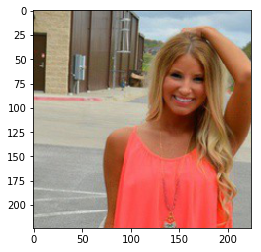

In [26]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, pretrain_dset_mean, pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


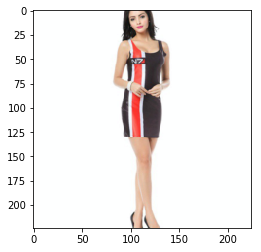

In [27]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, pretrain_dset_mean, pretrain_dset_std))
print(lbl2)

# DataLoader

In [28]:
if distributed:
    dist.init_process_group(backend=dist_backend,
                            init_method=dist_url,
                            world_size=world_size)


In [29]:
from torch.utils.data.distributed import DistributedSampler 


if distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers,
                                         pin_memory=True
                                        )


In [30]:
train_images, train_labels = next(iter(train_loader))

In [31]:
rnd11 = np.random.randint(batch_size)
print(train_images[rnd11,:,:,:])
print(train_labels[rnd11, :])

tensor([[[ 0.2624,  0.3481,  0.4851,  ...,  1.3070,  1.3242,  1.3242],
         [ 0.1083,  0.1768,  0.2967,  ...,  1.3242,  1.3070,  1.3070],
         [ 0.0227,  0.0912,  0.1768,  ...,  1.3242,  1.3070,  1.3070],
         ...,
         [ 0.7419,  0.7248,  0.7248,  ...,  1.1872,  1.1872,  1.2043],
         [ 0.7077,  0.7077,  0.7248,  ...,  1.1872,  1.1700,  1.1700],
         [ 0.7248,  0.7248,  0.7077,  ...,  1.1872,  1.1529,  1.1358]],

        [[-1.5455, -1.3354, -1.0028,  ...,  1.5357,  1.5532,  1.5532],
         [-1.5630, -1.3880, -1.1429,  ...,  1.5532,  1.5357,  1.5357],
         [-1.5630, -1.4230, -1.2304,  ...,  1.5532,  1.5357,  1.5357],
         ...,
         [-0.9328, -0.9503, -0.9503,  ...,  1.2906,  1.2906,  1.3081],
         [-0.9503, -0.9503, -0.9503,  ...,  1.3081,  1.2906,  1.2906],
         [-0.9328, -0.9328, -0.9503,  ...,  1.3431,  1.2906,  1.2731]],

        [[ 0.2871,  0.4439,  0.6879,  ...,  1.7337,  1.7511,  1.7511],
         [ 0.1128,  0.2173,  0.3916,  ...,  1

In [32]:
val_images, val_labels = next(iter(val_loader))

In [33]:
rnd21 = np.random.randint(batch_size)
print(val_images[rnd21,:,:,:])
print(val_labels[rnd21, :])

tensor([[[-1.8782, -1.8953, -1.8953,  ..., -2.0152, -2.0323, -2.0494],
         [-1.7754, -1.7925, -1.7754,  ..., -2.0152, -2.0494, -2.1008],
         [-1.7069, -1.7069, -1.6898,  ..., -2.0665, -2.0665, -2.1008],
         ...,
         [ 1.9064,  1.8893,  1.8722,  ...,  1.7523,  1.7352,  1.6667],
         [ 1.9064,  1.9064,  1.9235,  ...,  1.7523,  1.7523,  1.7009],
         [ 1.9235,  1.9407,  1.9407,  ...,  1.7009,  1.7352,  1.7009]],

        [[ 0.8179,  0.8004,  0.8004,  ...,  0.7654,  0.7654,  0.7654],
         [ 0.8004,  0.7829,  0.7829,  ...,  0.8004,  0.7829,  0.7829],
         [ 0.8179,  0.8004,  0.8354,  ...,  0.7304,  0.7304,  0.7654],
         ...,
         [ 1.8683,  1.8508,  1.8333,  ...,  1.6933,  1.6583,  1.6057],
         [ 1.8859,  1.8859,  1.9034,  ...,  1.6408,  1.6408,  1.6232],
         [ 1.9034,  1.9209,  1.9209,  ...,  1.6057,  1.6408,  1.6057]],

        [[ 1.8905,  1.8731,  1.8731,  ...,  1.8383,  1.8208,  1.8208],
         [ 1.8905,  1.8731,  1.8905,  ...,  1


# Model

In [34]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [35]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [36]:
model = create_model(arch, num_labels=228, fv_size=2048, pretrained=pretrained, resume=resume, distributed=distributed)

=> using pre-trained model 'resnet50'


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/sourabhd/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [02:07<00:00, 801469.21it/s]


In [37]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  23975204  trainable parameters


# Loss Function


In [38]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [40]:
optimizer = optim.Adam(model.parameters(), amsgrad=True, lr=optimizer_learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=scheduler_patience, threshold=scheduler_threshold, factor=scheduler_factor, verbose=1)


# Training Loop


# Save Results